In [1]:
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys
import pickle 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import corner

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import sys, platform, os
from numpy import sqrt, sin, cos, pi
import scipy.constants as cst

camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
tf.__version__

'2.8.0'

In [2]:
import scipy.integrate as integrate
import scipy.special as special     
from scipy.interpolate import CubicSpline
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.integrate import quad, dblquad

In [3]:
train_params = np.load('LHS_params_1dim15000_NL.npz')                #LHS  

In [4]:
print(train_params.files)                                       # Each of the keys has an 'np.array' of values

['h']


In [5]:
#print(train_params['omega_b'])

n_samples = len(train_params['h'])
print('number of training samples:', len(train_params['h'])) 
print(train_params['h'])

number of training samples: 15000
[0.7024575  0.68124008 0.74200147 ... 0.73954797 0.66450297 0.73618775]


In [6]:
cosmo_params = np.zeros((len(train_params['h']), 1))
print(cosmo_params[4])

cosmo_params[:, 0] = train_params['h']

## Training input params:
h = cosmo_params[:, 0]

[0.]


In [7]:
with open('pk_data_1dim15000_NL1.pkl', 'rb') as f, open('pk_data_1dim15000_NL2.pkl', 'rb') as g:
    pk_matrix = pickle.load(f)
    pk_nonlin_matrix = pickle.load(g)

pk_matrix = np.asarray(pk_matrix).astype('float32')
pk_matrix.dtype

In [8]:
h.dtype

dtype('float64')

In [9]:
# Training input params and output param:

train_H0 = 100*h                          
train_pk = pk_matrix                    
train_pk_nonlin = pk_nonlin_matrix
print("train_pk shape:", np.shape(train_pk))
print("train_pk_nonlin shape:", np.shape(train_pk_nonlin))
print(len(train_pk[4]))

train_pk shape: (15000, 500)
train_pk_nonlin shape: (15000, 500)
500


In [10]:
input_params = np.vstack([train_H0])                                        # 1x5000

input_params_transpose = np.transpose(input_params)
print(np.shape(input_params_transpose))
print(np.shape(train_pk))

input_data = pd.DataFrame(input_params_transpose)
input_data.columns = ['H0']

output_data = pd.DataFrame(np.log(train_pk))
output_data_nonlin = pd.DataFrame(np.log(train_pk_nonlin))  
print(input_data)                                                         #5000x1
print(output_data)

(15000, 1)
(15000, 500)
              H0
0      70.245750
1      68.124008
2      74.200147
3      77.892126
4      75.834389
...          ...
14995  79.737583
14996  69.247283
14997  73.954797
14998  66.450297
14999  73.618775

[15000 rows x 1 columns]
            0         1         2         3         4         5         6    \
0      6.153529  6.176601  6.199673  6.222743  6.245813  6.268883  6.291951   
1      6.074211  6.097284  6.120356  6.143427  6.166498  6.189569  6.212638   
2      6.296544  6.319614  6.342684  6.365754  6.388822  6.411890  6.434957   
3      6.424502  6.447572  6.470640  6.493708  6.516775  6.539841  6.562906   
4      6.353851  6.376921  6.399990  6.423059  6.446127  6.469194  6.492260   
...         ...       ...       ...       ...       ...       ...       ...   
14995  6.486371  6.509440  6.532508  6.555575  6.578641  6.601706  6.624770   
14996  6.116432  6.139505  6.162576  6.185647  6.208718  6.231788  6.254857   
14997  6.287851  6.310922  6.333992

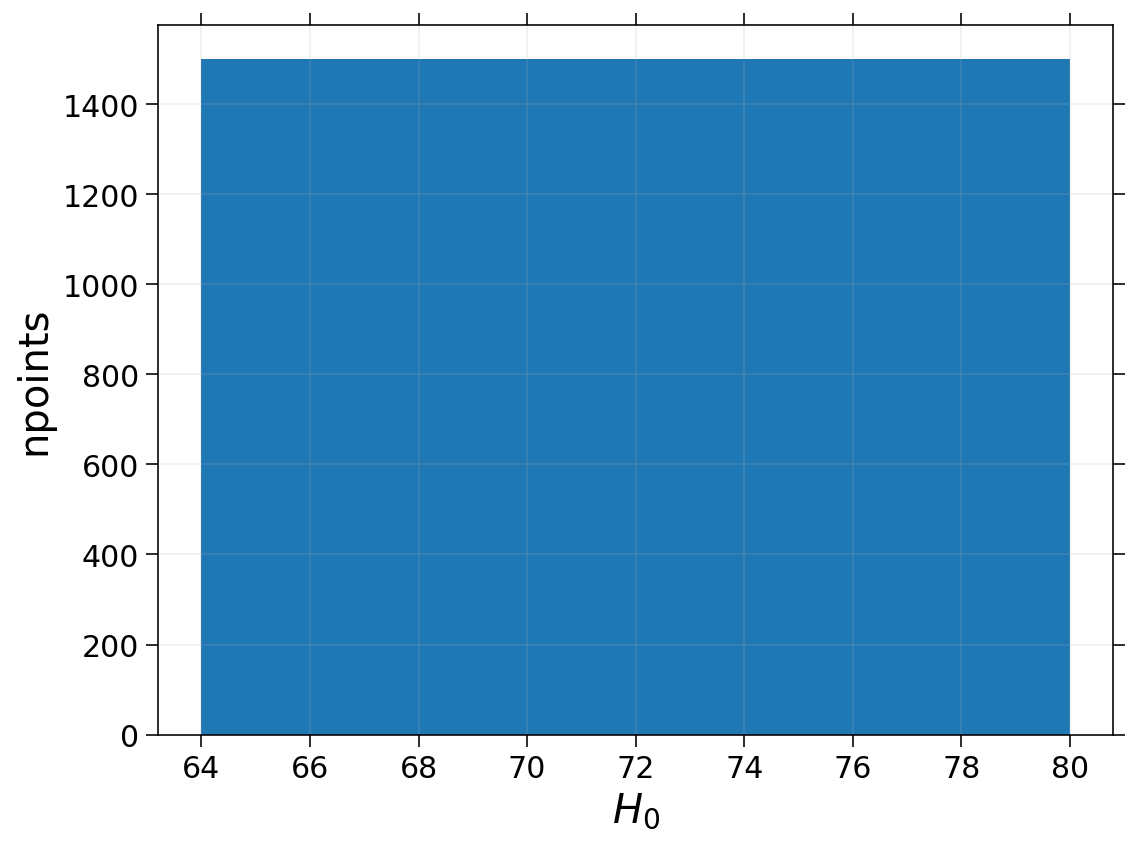

In [12]:
plt.figure(figsize = (8,6))
plt.hist(input_data['H0'])
plt.xlabel(r'$H_{0}$')
plt.ylabel('npoints')
plt.rc('axes', labelsize=16)
plt.rc('axes', labelsize=20, titlesize=20)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.grid(alpha=0.2)
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)
plt.tight_layout()

In [13]:
# Standardising:

train_input_data = StandardScaler()
test_output_data = StandardScaler()

# Storing the fit object for later reference
scaled_input = train_input_data.fit(input_data.values)              # Compute the mean and std to be used for later scaling

scaled_output = test_output_data.fit(output_data.values)
scaled_output_nonlin = test_output_data.fit(output_data_nonlin.values)

# Generating the standardized values of input and output:
X = scaled_input.transform(input_data.values)                              # Perform standardisation by centring and scaling    
y = scaled_output.transform(output_data.values)     
y_nonlin = scaled_output_nonlin.transform(output_data_nonlin.values)
#print(X)

-1.7319353413637846 21.55014009773678


(array([1500., 1500., 1500., 1500., 1500., 1500., 1500., 1500., 1500.,
        1500.]),
 array([-1.73193534e+00, -1.38554827e+00, -1.03916120e+00, -6.92774137e-01,
        -3.46387068e-01, -2.22044605e-16,  3.46387068e-01,  6.92774137e-01,
         1.03916120e+00,  1.38554827e+00,  1.73193534e+00]),
 <BarContainer object of 10 artists>)

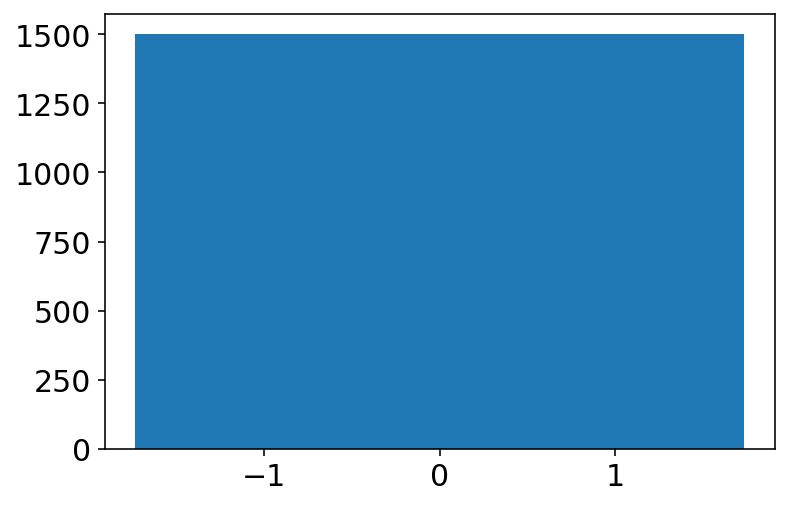

In [14]:
print(X.min(), y.max())
plt.hist(X)

In [15]:
# Split the data into training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(np.shape(X_train))    # 4000x1
print(X_train.shape[1])     # 1


X_train_nonlin, X_test_nonlin, y_train_nonlin, y_test_nonlin = train_test_split(X, y_nonlin, test_size=0.2, random_state=42)
print(np.shape(X_train_nonlin))
print(X_train.shape[1])    

(12000, 1)
1
(12000, 1)
1


In [16]:
print("y_test samples, pts:", np.shape(y_test))
print("y_train samples, pts:", np.shape(y_train))
print("X_train samples, pts:", np.shape(X_train))
print("X_test samples, pts:",np.shape(X_test))

print("y_test_nonlin samples, pts:", np.shape(y_test_nonlin))
print("y_train_nonlin samples, pts:", np.shape(y_train_nonlin))
print("X_train_nonlin samples, pts:", np.shape(X_train_nonlin))
print("X_test_nonlin samples, pts:",np.shape(X_test_nonlin))
#print("X_train:", X_train)
#print("X_test:", X_test)

y_test samples, pts: (3000, 500)
y_train samples, pts: (12000, 500)
X_train samples, pts: (12000, 1)
X_test samples, pts: (3000, 1)
y_test_nonlin samples, pts: (3000, 500)
y_train_nonlin samples, pts: (12000, 500)
X_train_nonlin samples, pts: (12000, 1)
X_test_nonlin samples, pts: (3000, 1)


In [18]:
%%time
#Building the NN:

# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01,
#                                   patience=30, min_lr=0.000000001)
# e_s = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100)

tf_model = Sequential()
# Defining the input layer of the model
tf_model.add(Dense(units=250, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu')) # 
 
# Defining 1st Hidden layer of the model
tf_model.add(Dense(units=250, kernel_initializer='normal', activation='relu'))

# Defining 2nd Hidden layer of the model
tf_model.add(Dense(units=250, kernel_initializer='normal', activation='relu'))

# Defining the 3rd hidden layer of the model
#tf_model.add(Dense(units=150, kernel_initializer='normal', activation='relu'))  

# Defining the 4th hidden layer of the model
#tf_model.add(Dense(units=150, kernel_initializer='normal', activation='relu')) 

#Defining the output layer of the model
tf_model.add(Dense(500, kernel_initializer='normal'))
 
# opt = keras.optimizers.Adam(learning_rate=1e-4)
opt = keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)  
    
# Compiling the model
tf_model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
 
# Fitting the ANN to the Training set
hist_ = tf_model.fit(X_train, y_train, batch_size = 20, epochs = 250, validation_split=0.2, verbose=1) # callbacks=[reduce_lr, e_s],
            
# Mean absolute percentage error
MAPE = np.mean(np.abs((y_test - tf_model.predict(X_test))/y_test))*100
print(np.shape(100-MAPE))
print('Accuracy:', 100-MAPE)
#99.44523163935358, l_rate = 1e-4, 250 epochs, batch size = 50, 0.9837
#99.59918915882399, l_rate = 1e-4, 250 epochs, batch size = 20, 0.9934
tf_model.summary()

Epoch 1/250
480/480 [==============================] - 2s 3ms/step - loss: 2071.0183 - accuracy: 0.3002 - val_loss: 82.2480 - val_accuracy: 0.4754
Epoch 2/250
480/480 [==============================] - 1s 3ms/step - loss: 35.5947 - accuracy: 0.4725 - val_loss: 12.8428 - val_accuracy: 0.4754
Epoch 3/250
480/480 [==============================] - 1s 3ms/step - loss: 8.2400 - accuracy: 0.4725 - val_loss: 4.8679 - val_accuracy: 0.4754
Epoch 4/250
480/480 [==============================] - 1s 3ms/step - loss: 3.8256 - accuracy: 0.4725 - val_loss: 2.8696 - val_accuracy: 0.4754
Epoch 5/250
480/480 [==============================] - 1s 3ms/step - loss: 2.4921 - accuracy: 0.4725 - val_loss: 2.0453 - val_accuracy: 0.4754
Epoch 6/250
480/480 [==============================] - 1s 3ms/step - loss: 1.7871 - accuracy: 0.4828 - val_loss: 1.5171 - val_accuracy: 0.4754
Epoch 7/250
480/480 [==============================] - 1s 3ms/step - loss: 1.3772 - accuracy: 0.4735 - val_loss: 1.2181 - val_accuracy: 

Epoch 58/250
480/480 [==============================] - 2s 3ms/step - loss: 0.0010 - accuracy: 0.9866 - val_loss: 9.5030e-04 - val_accuracy: 0.9808
Epoch 59/250
480/480 [==============================] - 2s 4ms/step - loss: 0.0010 - accuracy: 0.9858 - val_loss: 0.0013 - val_accuracy: 0.9787
Epoch 60/250
480/480 [==============================] - 2s 4ms/step - loss: 0.0012 - accuracy: 0.9846 - val_loss: 0.0016 - val_accuracy: 0.9871
Epoch 61/250
480/480 [==============================] - 2s 3ms/step - loss: 0.0023 - accuracy: 0.9865 - val_loss: 0.0074 - val_accuracy: 0.9804
Epoch 62/250
480/480 [==============================] - 2s 3ms/step - loss: 9.4942e-04 - accuracy: 0.9879 - val_loss: 7.4337e-04 - val_accuracy: 0.9887
Epoch 63/250
480/480 [==============================] - 1s 3ms/step - loss: 8.0412e-04 - accuracy: 0.9865 - val_loss: 7.1111e-04 - val_accuracy: 0.9933
Epoch 64/250
480/480 [==============================] - 1s 3ms/step - loss: 7.9264e-04 - accuracy: 0.9871 - val_loss

480/480 [==============================] - 1s 3ms/step - loss: 6.2766e-04 - accuracy: 0.9902 - val_loss: 4.3755e-04 - val_accuracy: 0.9946
Epoch 113/250
480/480 [==============================] - 1s 3ms/step - loss: 6.1199e-04 - accuracy: 0.9899 - val_loss: 3.1013e-04 - val_accuracy: 0.9867
Epoch 114/250
480/480 [==============================] - 1s 3ms/step - loss: 7.3416e-04 - accuracy: 0.9883 - val_loss: 2.8540e-04 - val_accuracy: 0.9875
Epoch 115/250
480/480 [==============================] - 2s 4ms/step - loss: 5.4744e-04 - accuracy: 0.9893 - val_loss: 4.2549e-04 - val_accuracy: 0.9937
Epoch 116/250
480/480 [==============================] - 1s 3ms/step - loss: 8.1628e-04 - accuracy: 0.9910 - val_loss: 3.4166e-04 - val_accuracy: 0.9967
Epoch 117/250
480/480 [==============================] - 1s 3ms/step - loss: 3.9153e-04 - accuracy: 0.9901 - val_loss: 3.3865e-04 - val_accuracy: 0.9925
Epoch 118/250
480/480 [==============================] - 2s 3ms/step - loss: 6.6195e-04 - accura

Epoch 166/250
480/480 [==============================] - 1s 3ms/step - loss: 5.1998e-04 - accuracy: 0.9916 - val_loss: 3.7209e-04 - val_accuracy: 0.9896
Epoch 167/250
480/480 [==============================] - 1s 3ms/step - loss: 8.1426e-04 - accuracy: 0.9915 - val_loss: 2.6460e-04 - val_accuracy: 0.9971
Epoch 168/250
480/480 [==============================] - 1s 3ms/step - loss: 2.8102e-04 - accuracy: 0.9933 - val_loss: 2.3194e-04 - val_accuracy: 0.9925
Epoch 169/250
480/480 [==============================] - 1s 3ms/step - loss: 4.3550e-04 - accuracy: 0.9914 - val_loss: 2.4588e-04 - val_accuracy: 0.9896
Epoch 170/250
480/480 [==============================] - 1s 3ms/step - loss: 5.4974e-04 - accuracy: 0.9919 - val_loss: 6.4086e-04 - val_accuracy: 0.9921
Epoch 171/250
480/480 [==============================] - 1s 3ms/step - loss: 6.9263e-04 - accuracy: 0.9904 - val_loss: 6.1929e-04 - val_accuracy: 0.9850
Epoch 172/250
480/480 [==============================] - 1s 3ms/step - loss: 3.276

Epoch 220/250
480/480 [==============================] - 1s 3ms/step - loss: 3.5068e-04 - accuracy: 0.9932 - val_loss: 2.2290e-04 - val_accuracy: 0.9950
Epoch 221/250
480/480 [==============================] - 1s 3ms/step - loss: 8.5034e-04 - accuracy: 0.9906 - val_loss: 4.0355e-04 - val_accuracy: 0.9962
Epoch 222/250
480/480 [==============================] - 2s 3ms/step - loss: 2.5394e-04 - accuracy: 0.9922 - val_loss: 1.9870e-04 - val_accuracy: 0.9975
Epoch 223/250
480/480 [==============================] - 2s 4ms/step - loss: 3.6148e-04 - accuracy: 0.9930 - val_loss: 1.8405e-04 - val_accuracy: 0.9942
Epoch 224/250
480/480 [==============================] - 2s 3ms/step - loss: 7.6869e-04 - accuracy: 0.9931 - val_loss: 4.2684e-04 - val_accuracy: 0.9942
Epoch 225/250
480/480 [==============================] - 1s 3ms/step - loss: 1.9924e-04 - accuracy: 0.9935 - val_loss: 2.1026e-04 - val_accuracy: 0.9950
Epoch 226/250
480/480 [==============================] - 2s 4ms/step - loss: 8.596

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

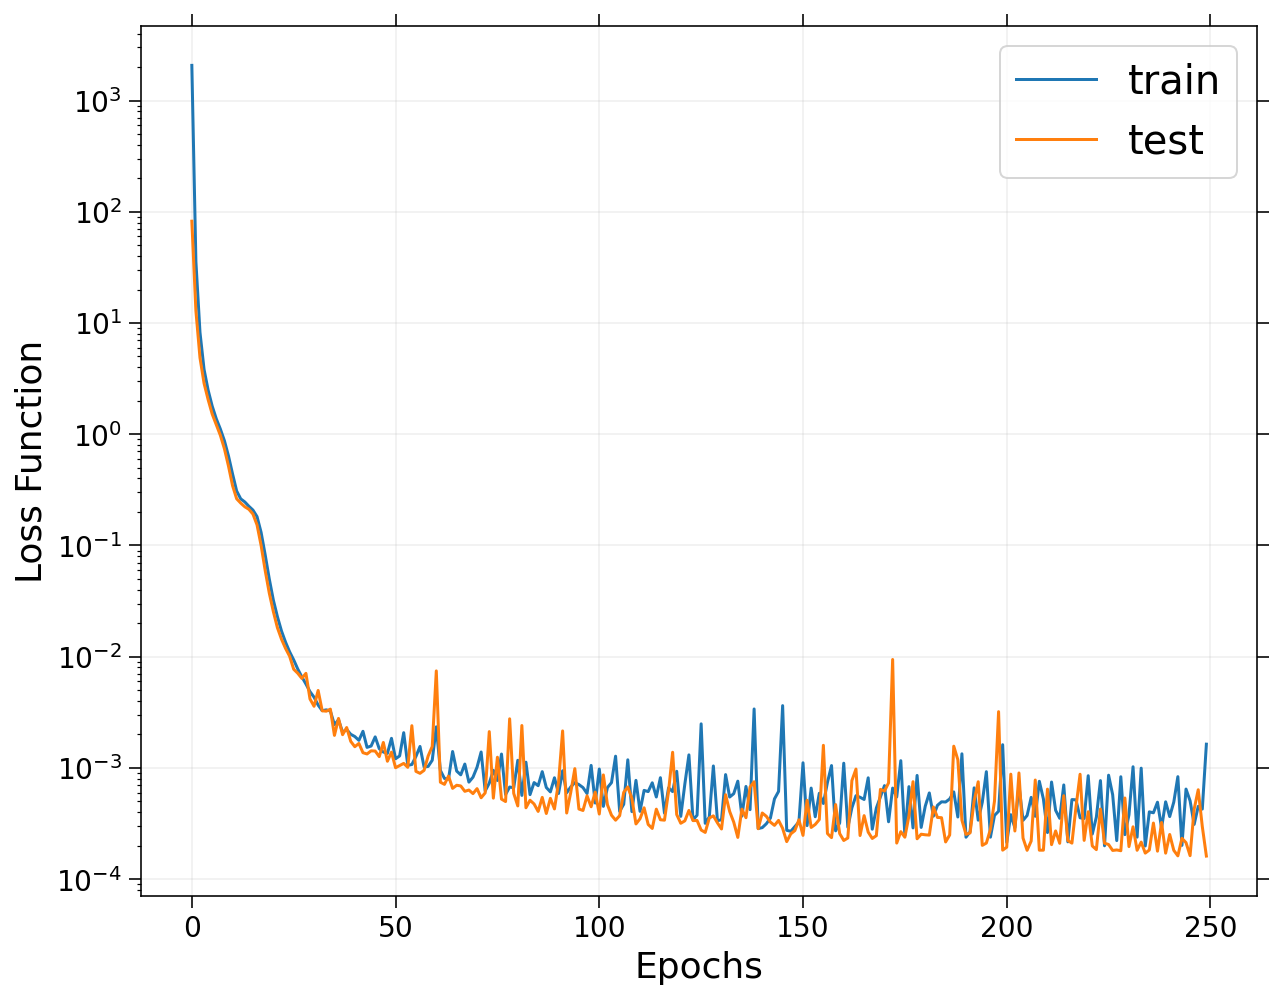

In [26]:
#Linear case:
plt.figure(figsize = (10,8))
plt.plot(hist_.history["loss"], label="train")
plt.plot(hist_.history["val_loss"], label="test")
plt.legend(fontsize=20)
plt.yscale("log")
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.rc('axes', labelsize=16)
plt.rc('axes', labelsize=20, titlesize=20)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.grid(alpha=0.2)
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)
plt.savefig('Loss_Func_1dim_H0.pdf')
plt.tight_layout

In [21]:
%%time
#Building the NN for NONLINEAR:

# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01,
#                                   patience=30, min_lr=0.000000001)
# e_s = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100)

tf_model_nonlin = Sequential()
# Defining the input layer of the model
tf_model_nonlin.add(Dense(units=250, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu')) # 
 
# Defining 1st Hidden layer of the model
tf_model_nonlin.add(Dense(units=250, kernel_initializer='normal', activation='relu'))

# Defining 2nd Hidden layer of the model
tf_model_nonlin.add(Dense(units=250, kernel_initializer='normal', activation='relu'))

# Defining the 3rd hidden layer of the model
#tf_model_nonlin.add(Dense(units=150, kernel_initializer='normal', activation='relu'))  

# Defining the 4th hidden layer of the model
#tf_model_nonlin.add(Dense(units=150, kernel_initializer='normal', activation='relu')) 

#Defining the output layer of the model
tf_model_nonlin.add(Dense(500, kernel_initializer='normal'))
 
# opt = keras.optimizers.Adam(learning_rate=1e-4)
#opt = keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)  
    
# Compiling the model
tf_model_nonlin.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
 
# Fitting the ANN to the Training set
hist_nonlin = tf_model_nonlin.fit(X_train_nonlin, y_train_nonlin, batch_size = 20, epochs = 250, validation_split=0.2, verbose=1) # callbacks=[reduce_lr, e_s],
            
# Mean absolute percentage error
MAPE = np.mean(np.abs((y_test_nonlin - tf_model_nonlin.predict(X_test_nonlin))/y_test_nonlin))*100
print(np.shape(100-MAPE))
print('Accuracy:', 100-MAPE)
#99.44523163935358, l_rate = 1e-4, 250 epochs, batch size = 50, 0.9837
#99.59918915882399, l_rate = 1e-4, 250 epochs, batch size = 20, 0.9934
tf_model_nonlin.summary()

Epoch 1/250
480/480 [==============================] - 2s 3ms/step - loss: 0.0746 - accuracy: 0.0983 - val_loss: 0.0110 - val_accuracy: 0.2925
Epoch 2/250
480/480 [==============================] - 1s 3ms/step - loss: 0.0063 - accuracy: 0.4772 - val_loss: 0.0041 - val_accuracy: 0.4933
Epoch 3/250
480/480 [==============================] - 1s 3ms/step - loss: 0.0027 - accuracy: 0.5602 - val_loss: 0.0014 - val_accuracy: 0.6133
Epoch 4/250
480/480 [==============================] - 1s 3ms/step - loss: 8.8196e-04 - accuracy: 0.6044 - val_loss: 4.9671e-04 - val_accuracy: 0.6804
Epoch 5/250
480/480 [==============================] - 1s 3ms/step - loss: 3.6637e-04 - accuracy: 0.7592 - val_loss: 2.4991e-04 - val_accuracy: 0.8138
Epoch 6/250
480/480 [==============================] - 2s 3ms/step - loss: 1.9907e-04 - accuracy: 0.8382 - val_loss: 1.4965e-04 - val_accuracy: 0.8504
Epoch 7/250
480/480 [==============================] - 1s 3ms/step - loss: 1.2873e-04 - accuracy: 0.8512 - val_loss: 1

480/480 [==============================] - 1s 3ms/step - loss: 2.2066e-05 - accuracy: 0.9321 - val_loss: 2.9715e-05 - val_accuracy: 0.9117
Epoch 56/250
480/480 [==============================] - 2s 3ms/step - loss: 2.1732e-05 - accuracy: 0.9339 - val_loss: 2.1896e-05 - val_accuracy: 0.9121
Epoch 57/250
480/480 [==============================] - 1s 3ms/step - loss: 2.1602e-05 - accuracy: 0.9332 - val_loss: 6.6334e-05 - val_accuracy: 0.9267
Epoch 58/250
480/480 [==============================] - 1s 3ms/step - loss: 2.0975e-05 - accuracy: 0.9320 - val_loss: 1.9175e-05 - val_accuracy: 0.9262
Epoch 59/250
480/480 [==============================] - 2s 4ms/step - loss: 2.1359e-05 - accuracy: 0.9321 - val_loss: 2.1243e-05 - val_accuracy: 0.9396
Epoch 60/250
480/480 [==============================] - 2s 4ms/step - loss: 1.9883e-05 - accuracy: 0.9339 - val_loss: 2.1038e-05 - val_accuracy: 0.9262
Epoch 61/250
480/480 [==============================] - 1s 3ms/step - loss: 2.4030e-05 - accuracy: 0.

Epoch 109/250
480/480 [==============================] - 1s 3ms/step - loss: 1.9529e-05 - accuracy: 0.9503 - val_loss: 1.5809e-05 - val_accuracy: 0.9438
Epoch 110/250
480/480 [==============================] - 1s 3ms/step - loss: 1.6284e-05 - accuracy: 0.9459 - val_loss: 1.5528e-05 - val_accuracy: 0.9400
Epoch 111/250
480/480 [==============================] - 1s 3ms/step - loss: 1.9345e-05 - accuracy: 0.9494 - val_loss: 2.3268e-05 - val_accuracy: 0.9354
Epoch 112/250
480/480 [==============================] - 1s 3ms/step - loss: 1.6269e-05 - accuracy: 0.9496 - val_loss: 1.7338e-05 - val_accuracy: 0.9408
Epoch 113/250
480/480 [==============================] - 1s 3ms/step - loss: 1.6291e-05 - accuracy: 0.9460 - val_loss: 2.3825e-05 - val_accuracy: 0.9571
Epoch 114/250
480/480 [==============================] - 1s 3ms/step - loss: 1.8968e-05 - accuracy: 0.9492 - val_loss: 1.5259e-05 - val_accuracy: 0.9362
Epoch 115/250
480/480 [==============================] - 1s 3ms/step - loss: 1.664

480/480 [==============================] - 1s 3ms/step - loss: 1.5812e-05 - accuracy: 0.9566 - val_loss: 1.3468e-05 - val_accuracy: 0.9542
Epoch 163/250
480/480 [==============================] - 1s 3ms/step - loss: 1.6454e-05 - accuracy: 0.9568 - val_loss: 1.3471e-05 - val_accuracy: 0.9400
Epoch 164/250
480/480 [==============================] - 2s 4ms/step - loss: 1.5479e-05 - accuracy: 0.9592 - val_loss: 1.3926e-05 - val_accuracy: 0.9567
Epoch 165/250
480/480 [==============================] - 2s 3ms/step - loss: 1.4166e-05 - accuracy: 0.9564 - val_loss: 1.2984e-05 - val_accuracy: 0.9579
Epoch 166/250
480/480 [==============================] - 1s 3ms/step - loss: 1.4041e-05 - accuracy: 0.9590 - val_loss: 1.3074e-05 - val_accuracy: 0.9604
Epoch 167/250
480/480 [==============================] - 1s 3ms/step - loss: 1.3658e-05 - accuracy: 0.9574 - val_loss: 1.4689e-05 - val_accuracy: 0.9654
Epoch 168/250
480/480 [==============================] - 1s 3ms/step - loss: 1.7390e-05 - accura

480/480 [==============================] - 1s 3ms/step - loss: 1.2701e-05 - accuracy: 0.9604 - val_loss: 1.0995e-05 - val_accuracy: 0.9579
Epoch 216/250
480/480 [==============================] - 1s 3ms/step - loss: 1.2805e-05 - accuracy: 0.9603 - val_loss: 2.9656e-05 - val_accuracy: 0.9558
Epoch 217/250
480/480 [==============================] - 1s 3ms/step - loss: 1.5919e-05 - accuracy: 0.9601 - val_loss: 1.1933e-05 - val_accuracy: 0.9525
Epoch 218/250
480/480 [==============================] - 1s 3ms/step - loss: 1.2500e-05 - accuracy: 0.9604 - val_loss: 1.4089e-05 - val_accuracy: 0.9604
Epoch 219/250
480/480 [==============================] - 1s 3ms/step - loss: 1.3159e-05 - accuracy: 0.9603 - val_loss: 1.1843e-05 - val_accuracy: 0.9554
Epoch 220/250
480/480 [==============================] - 1s 3ms/step - loss: 1.3073e-05 - accuracy: 0.9600 - val_loss: 1.1218e-05 - val_accuracy: 0.9642
Epoch 221/250
480/480 [==============================] - 1s 3ms/step - loss: 1.5709e-05 - accura

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

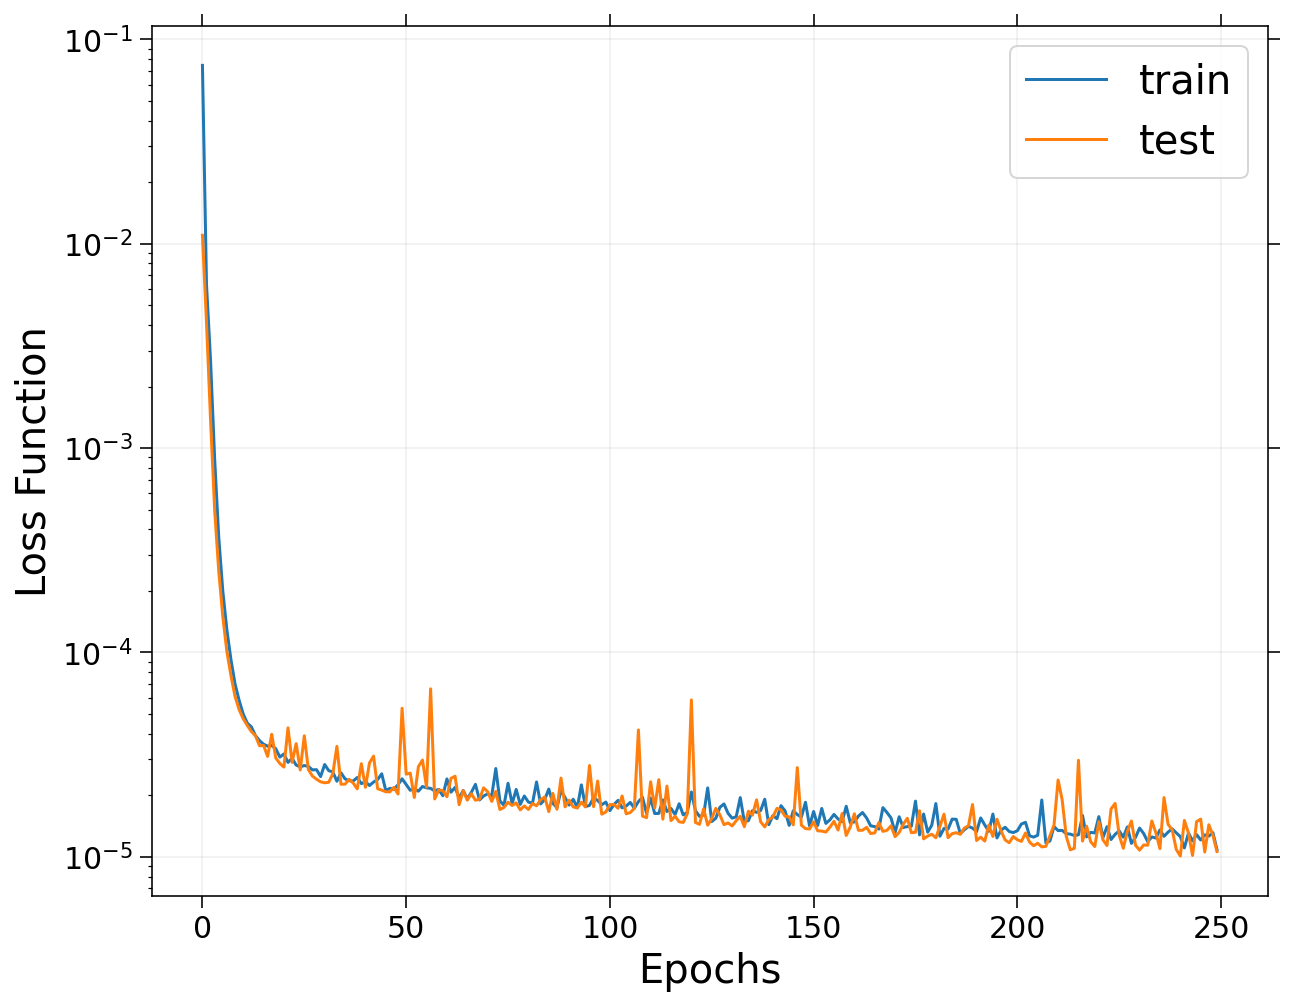

In [27]:
plt.figure(figsize = (10,8))
plt.plot(hist_nonlin.history["loss"], label="train")
plt.plot(hist_nonlin.history["val_loss"], label="test")
plt.legend(fontsize=20)
plt.yscale("log")
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.rc('axes', labelsize=16)
plt.rc('axes', labelsize=20, titlesize=20)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.grid(alpha=0.2)
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)
plt.savefig('Loss_Func_1dim_NL_H0.pdf')
plt.tight_layout

H0: 64.0 - 80.0 67.66


parameter:  ['67.66']
user_list: [67.66]
cosmo_arr [[67.66]]
cosmo_arr[0] [67.66]
input_scaled [[-0.93957492]]
H0: 67.66


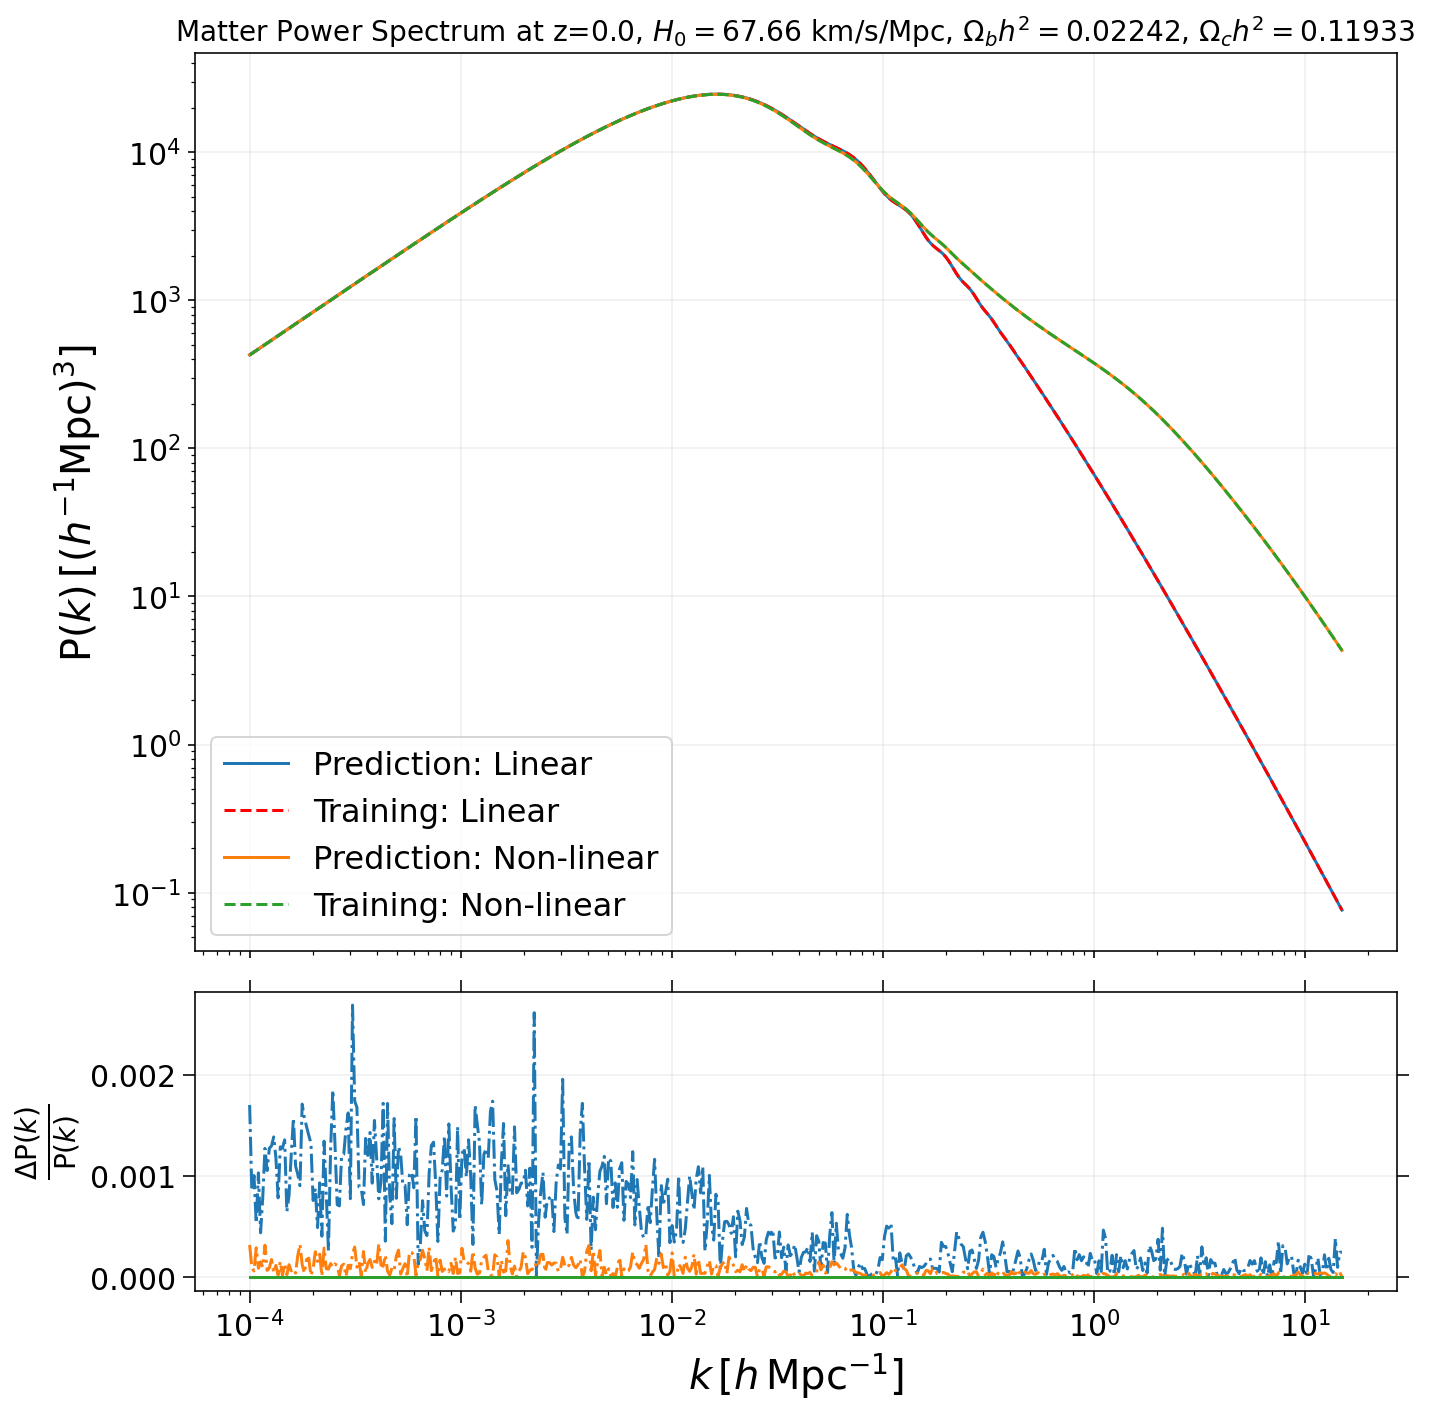

In [28]:
#Define func:

def calc_cosmo():
    input_cosmo_val = input('H0: 64.0 - 80.0 ')
    print("\n")
    user_list = input_cosmo_val.split()
    # print list
    print('parameter: ', user_list)

    # convert each item to float type
    for i in range(len(user_list)):
        # convert each item to float type
        user_list[i] = float(user_list[i])
    print("user_list:", user_list)
        
    
    cosmo_arr = np.reshape(np.array(user_list),(1, X_train.shape[1]))
    print('cosmo_arr', cosmo_arr)
    print('cosmo_arr[0]', cosmo_arr[0])
    scaled = train_input_data.fit(input_data.values)
    input_scaled = scaled.transform(cosmo_arr)
    #input_scaled_nonlin = scaled.transform(cosmo_arr_nonlin)
    print('input_scaled', input_scaled)
    
    pred_pk = np.exp(scaled_output.inverse_transform(tf_model.predict([input_scaled])))
    pred_pk_nonlin = np.exp(scaled_output.inverse_transform(tf_model_nonlin.predict([input_scaled])))
    #Return to log scale for pred:
    #pred_pk = np.exp(pred_rescaled_pk)
    
    
    #Compute P.S via CAMB:
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=cosmo_arr[0][0], ombh2=0.02242, omch2=0.11933)
    pars.InitPower.set_params(As = 2.105209331e-9, ns=0.9665)
    pars.set_matter_power(redshifts=[0.0], kmax=15.0)
    pars.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')

    # Linear spectra
    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    camb_kh, z, camb_pk_cur = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints=500)
    s8_current = np.array(results.get_sigma8())
    s8_fid = np.array([0.8102])
    renorm_s8 = (s8_fid/s8_current)**2
    camb_pk = renorm_s8*camb_pk_cur

    # Non-Linear spectra (Halofit)
    pars.NonLinear = model.NonLinear_both
    results.calc_power_spectra(pars)
    camb_kh_nonlin, z_nonlin, camb_pk_nonlin_cur = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints = 500)
    camb_pk_nonlin = renorm_s8*camb_pk_nonlin_cur

    print('H0:' , cosmo_arr[0][0])
    #print(pred_pk)
    
    fig, ax = plt.subplots(2,1, sharex=True, figsize = (10,10), gridspec_kw={'height_ratios': [3, 1]})                                            
    ax[0].loglog(camb_kh, pred_pk[0], "C0")                                                          # prediction                            
    ax[0].loglog(camb_kh, camb_pk[0], 'r', linestyle='dashed')                                          # CAMB
    ax[0].loglog(camb_kh, pred_pk_nonlin[0], "C1")
    ax[0].loglog(camb_kh, camb_pk_nonlin[0], 'C2', linestyle='dashed') 
    ax[0].set_title('Matter Power Spectrum at z=0.0, $H_{0} = %0.5s \ \mathregular{km/s/Mpc}$, ' %cosmo_arr[0][0] + '$\Omega_{b}h^{2} = 0.02242$, ' + '$\Omega_{c}h^{2} = 0.11933$ ', fontsize = 14)
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=16)
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
    plt.xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
    ax[0].set_ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
    ax[0].legend(['Prediction: Linear', 'Training: Linear', 'Prediction: Non-linear', 'Training: Non-linear'], loc='lower left', fontsize=16);
    ax[0].grid(alpha=0.2)
    ax[1].grid(alpha=0.2)
    plt.tick_params(top=True,right=True, length=6)
    
    #residual plot 
    ax[1].set_ylabel(r'$\frac{\Delta \mathrm{P}(k)}{\mathrm{P}(k)}$')
    ax[1].plot(camb_kh, np.abs((pred_pk[0]-camb_pk[0])/camb_pk[0]), 'C0', linestyle="dashdot") 
    ax[1].plot(camb_kh, np.abs((camb_pk[0]-camb_pk[0])/camb_pk[0]), 'r')
    ax[1].plot(camb_kh, np.abs((pred_pk_nonlin[0]-camb_pk_nonlin[0])/camb_pk_nonlin[0]), 'C1', linestyle="dashdot") 
    ax[1].plot(camb_kh, np.abs((camb_pk_nonlin[0]-camb_pk_nonlin[0])/camb_pk_nonlin[0]), 'C2')
    ax[1].set_yscale('linear')
    #ax[1].set_ylim(0, 0.05)
    fig.tight_layout()
    plt.savefig('NLMPS_1dim_H0.pdf')
    plt.show()
    

Generate = calc_cosmo()

In [ ]:
#Define func:

def calc_cosmo():
    fig, ax = plt.subplots(1,2, sharex=True, figsize = (16,8)) #, gridspec_kw={'height_ratios': [3, 1]}
    H0_input = np.linspace(64.0, 80.0, 8)
    for w in H0_input:
        
        print("\n")
        user_list = float(w)
        # print list
        print('parameter: ', user_list)

        # convert each item to float type
        print("user_list:", user_list)
        
    
        cosmo_arr = np.reshape(np.array(user_list),(1, X_train.shape[1]))
        print('cosmo_arr', cosmo_arr)
        print('cosmo_arr[0]', cosmo_arr[0])
        scaled = train_input_data.fit(input_data.values)
        input_scaled = scaled.transform(cosmo_arr)
        print('input_scaled', input_scaled)

        pred_pk = np.exp(scaled_output.inverse_transform(tf_model.predict([input_scaled])))
        pred_pk_nonlin = np.exp(scaled_output.inverse_transform(tf_model_nonlin.predict([input_scaled])))
        #Return to log scale for pred:
        #pred_pk = np.exp(pred_rescaled_pk)
    
    
        #Compute P.S via CAMB:
        pars = camb.CAMBparams()
        pars.set_cosmology(H0=cosmo_arr[0][0], ombh2=0.02242, omch2=0.11933)
        pars.InitPower.set_params(As = 2.105209331e-9, ns=0.9665)
        pars.set_matter_power(redshifts=[0.0], kmax=15.0)
        pars.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')

        # Linear spectra
        pars.NonLinear = model.NonLinear_none
        results = camb.get_results(pars)
        camb_kh, z, camb_pk_cur = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints=500)
        s8_current = np.array(results.get_sigma8())
        s8_fid = np.array([0.8102])
        renorm_s8 = (s8_fid/s8_current)**2
        camb_pk = renorm_s8*camb_pk_cur

        # Non-Linear spectra (Halofit)
        pars.NonLinear = model.NonLinear_both
        results.calc_power_spectra(pars)
        camb_kh_nonlin, z_nonlin, camb_pk_nonlin_cur = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints = 500)
        camb_pk_nonlin = renorm_s8*camb_pk_nonlin_cur

        print('H0:' , cosmo_arr[0][0])
                                            
        ax[0].loglog(camb_kh, pred_pk[0])                                                                                   
        ax[1].loglog(camb_kh, pred_pk_nonlin[0])                                                  
    fig.suptitle('Emulation of Matter Power Spectra at z=0.0, ' + '$\Omega_{b}h^{2} = 0.02242$, ' + '$\Omega_{c}h^{2} = 0.11933$, ', fontsize = 14)
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=16)
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
    ax[0].set_xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
    ax[0].set_ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
    ax[0].legend(["$H_{0}\,\mathregular{(km/s/Mpc)} = %0.5s$"%w for w in  H0_input], loc='lower left', fontsize=16);
    ax[0].grid(alpha=0.2)
    ax[1].grid(alpha=0.2)
    ax[0].tick_params(top=True,right=True, length=6)
    
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=16)
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
    ax[1].set_xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
    ax[1].set_ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
    ax[1].legend(["$H_{0}\,\mathregular{(km/s/Mpc)} = %0.5s$"%w for w in  H0_input], loc='lower left', fontsize=16);
    ax[1].tick_params(top=True,right=True, length=6)

    fig.tight_layout()
    #plt.savefig('NN_MPS_H0_range.jpg')
    plt.show()
    

Generate = calc_cosmo()



parameter:  64.0
user_list: 64.0
cosmo_arr [[64.]]
cosmo_arr[0] [64.]
input_scaled [[-1.73193534]]
H0: 64.0


parameter:  66.28571428571429
user_list: 66.28571428571429
cosmo_arr [[66.28571429]]
cosmo_arr[0] [66.28571429]
input_scaled [[-1.23709667]]
H0: 66.28571428571429


parameter:  68.57142857142857
user_list: 68.57142857142857
cosmo_arr [[68.57142857]]
cosmo_arr[0] [68.57142857]
input_scaled [[-0.742258]]
H0: 68.57142857142857


parameter:  70.85714285714286
user_list: 70.85714285714286
cosmo_arr [[70.85714286]]
cosmo_arr[0] [70.85714286]
input_scaled [[-0.24741933]]
H0: 70.85714285714286


parameter:  73.14285714285714
user_list: 73.14285714285714
cosmo_arr [[73.14285714]]
cosmo_arr[0] [73.14285714]
input_scaled [[0.24741933]]
H0: 73.14285714285714


parameter:  75.42857142857143
user_list: 75.42857142857143
cosmo_arr [[75.42857143]]
cosmo_arr[0] [75.42857143]
input_scaled [[0.742258]]
H0: 75.42857142857143


parameter:  77.71428571428571
user_list: 77.71428571428571
cosmo_arr 

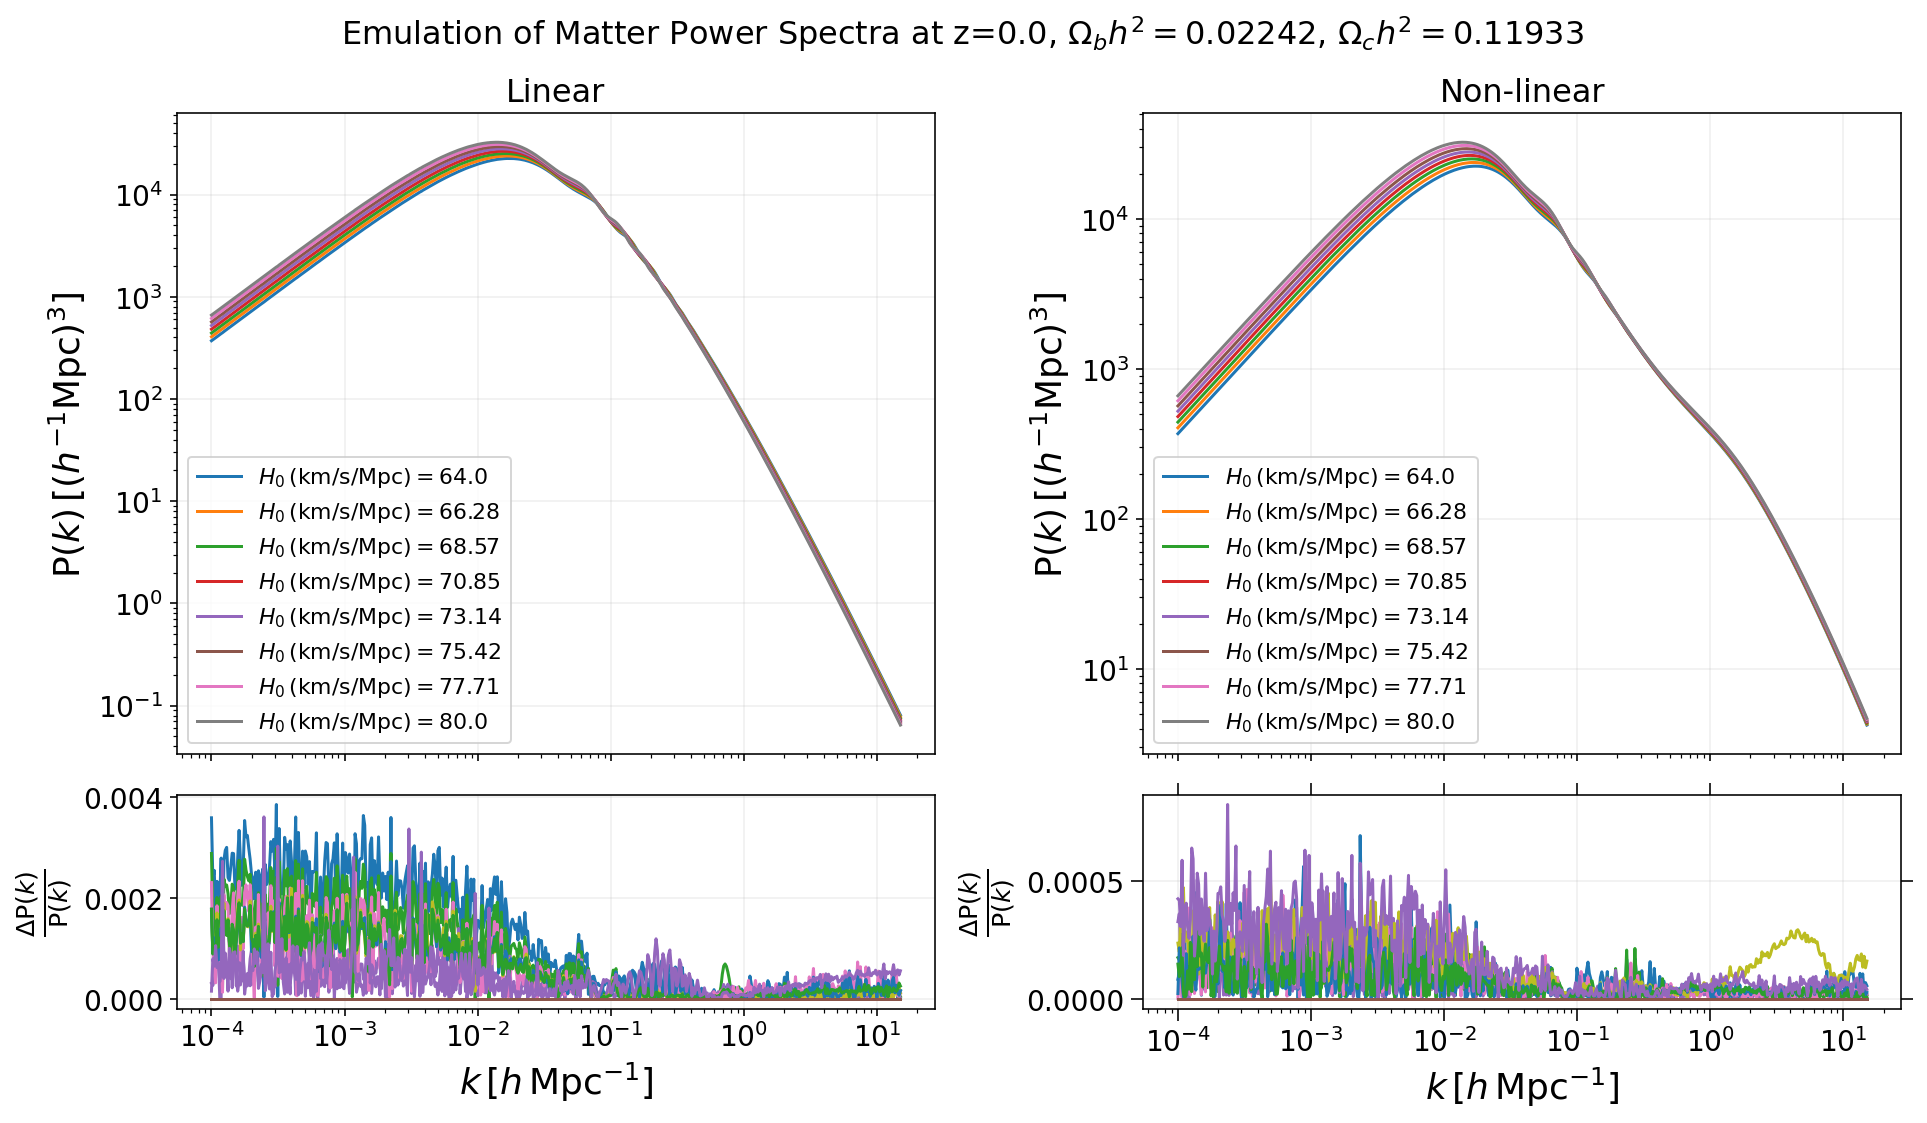

In [29]:
# Define func:

def calc_cosmo():
    
    fig, ax = plt.subplots(2,2, sharex=True, figsize = (13.5,8), gridspec_kw={'height_ratios': [3, 1]})
    H0_input = np.linspace(64.0, 80.0, 8)
    for w in H0_input:
        
        print("\n")
        user_list = float(w)
        # print list
        print('parameter: ', user_list)

        # convert each item to float type
        print("user_list:", user_list)
        
    
        cosmo_arr = np.reshape(np.array(user_list),(1, X_train.shape[1]))
        print('cosmo_arr', cosmo_arr)
        print('cosmo_arr[0]', cosmo_arr[0])
        scaled = train_input_data.fit(input_data.values)
        input_scaled = scaled.transform(cosmo_arr)
        print('input_scaled', input_scaled)

        pred_pk = np.exp(scaled_output.inverse_transform(tf_model.predict([input_scaled])))
        pred_pk_nonlin = np.exp(scaled_output.inverse_transform(tf_model_nonlin.predict([input_scaled])))
        #Return to log scale for pred:
        #pred_pk = np.exp(pred_rescaled_pk)
    
    
        #Compute P.S via CAMB:
        pars = camb.CAMBparams()
        pars.set_cosmology(H0=cosmo_arr[0][0], ombh2=0.02242, omch2=0.11933)
        pars.InitPower.set_params(As = 2.105209331e-9, ns=0.9665)
        pars.set_matter_power(redshifts=[0.0], kmax=15.0)
        pars.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')

        # Linear spectra
        pars.NonLinear = model.NonLinear_none
        results = camb.get_results(pars)
        camb_kh, z, camb_pk_cur = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints=500)
        s8_current = np.array(results.get_sigma8())
        s8_fid = np.array([0.8102])
        renorm_s8 = (s8_fid/s8_current)**2
        camb_pk = renorm_s8*camb_pk_cur
        
        
        # Non-Linear spectra (Halofit)
        pars.NonLinear = model.NonLinear_both
        results.calc_power_spectra(pars)
        camb_kh_nonlin, z_nonlin, camb_pk_nonlin_cur = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints = 500)
        camb_pk_nonlin = renorm_s8*camb_pk_nonlin_cur


        print('H0:' , cosmo_arr[0][0])
        
                                             
        ax[0,0].loglog(camb_kh, pred_pk[0])                                                                       
        ax[0,1].loglog(camb_kh, pred_pk_nonlin[0])
        
        #residual plot 
        ax[1,0].set_ylabel(r'$\frac{\Delta \mathrm{P}(k)}{\mathrm{P}(k)}$')
        ax[1,0].plot(camb_kh, np.abs((pred_pk[0]-camb_pk[0])/camb_pk[0])) 
        ax[1,0].plot(camb_kh, np.abs((camb_pk[0]-camb_pk[0])/camb_pk[0]))
        ax[1,0].set_yscale('linear')
        
        ax[1,1].set_ylabel(r'$\frac{\Delta \mathrm{P}(k)}{\mathrm{P}(k)}$')
        ax[1,1].plot(camb_kh, np.abs((pred_pk_nonlin[0]-camb_pk_nonlin[0])/camb_pk_nonlin[0])) 
        ax[1,1].plot(camb_kh, np.abs((camb_pk_nonlin[0]-camb_pk_nonlin[0])/camb_pk_nonlin[0]))
        ax[1,1].set_yscale('linear')
        #ax[1].set_ylim(0, 0.05)
        
    fig.suptitle('Emulation of Matter Power Spectra at z=0.0, ' + '$\Omega_{b}h^{2} = 0.02242$, ' + '$\Omega_{c}h^{2} = 0.11933$', fontsize = 16)
    ax[0,0].set_title('Linear')
    ax[0,1].set_title('Non-linear')
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=16)
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
    ax[1,0].set_xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
    ax[1,1].set_xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
    ax[0,0].set_ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
    ax[0,1].set_ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
    ax[0,0].legend(["$H_{0}\,\mathregular{(km/s/Mpc)} = %0.5s$"%w for w in  H0_input], loc='lower left', fontsize=11);
    ax[0,1].legend(["$H_{0}\,\mathregular{(km/s/Mpc)} = %0.5s$"%w for w in  H0_input], loc='lower left', fontsize=11);
    ax[0,0].grid(alpha=0.2)
    ax[1,0].grid(alpha=0.2)
    ax[0,1].grid(alpha=0.2)
    ax[1,1].grid(alpha=0.2)
    plt.tick_params(top=True,right=True, length=6)


        
    fig.tight_layout()
    plt.savefig('NLMPS_1dim_H0_range.pdf')
    plt.show()
    

Generate = calc_cosmo()